<a href="https://colab.research.google.com/github/omarAlnosyan/arabert-finetuning-arabic-news-classification/blob/main/fine_tuning_news_classfction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1: Install Libraries


In [ ]:
# Install required libraries
!pip install -q transformers datasets torch torchmetrics scikit-learn pandas numpy accelerate

print("Installation completed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 57.3 MB/s eta 0:00:00
Installation completed successfully!


Step 2: Import Libraries


In [ ]:
import random
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

# Transformers
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    get_linear_schedule_with_warmup
)

# Set seed
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


Step 3: Configuration


In [ ]:
# Project configuration
CONFIG = {
    'model_name': 'aubmindlab/bert-base-arabertv2',
    'max_length': 128,
    'batch_size': 16,
    'learning_rate': 2e-5,
    'num_epochs': 3,
    'test_size': 0.2,
    'val_size': 0.1,
}

print("Configuration:")
for key, value in CONFIG.items():
    print(f"   {key}: {value}")

Configuration:
   model_name: aubmindlab/bert-base-arabertv2
   max_length: 128
   batch_size: 16
   learning_rate: 2e-05
   num_epochs: 3
   test_size: 0.2
   val_size: 0.1


Step 4: Download Dataset


In [ ]:
import kagglehub

# Download dataset
print("Downloading SANAD Arabic News Dataset...")
path = kagglehub.dataset_download("haithemhermessi/sanad-dataset")
print(f"Dataset path: {path}")

100%|██████████| 65.7M/65.7M [00:04<00:00, 16.2MB/s]

Extracting files...


Dataset path: /root/.cache/kagglehub/datasets/haithemhermessi/sanad-dataset/versions/1


Step 5: Load Dataset


In [ ]:
import os

dataset_path = path

# Store all data
all_data = []

# Categories
categories = ['Sports', 'Politics', 'Finance', 'Medical', 'Tech', 'Culture', 'Religion']

print("Loading data from all categories...")

for category in categories:
    category_path = os.path.join(dataset_path, category)

    if os.path.exists(category_path):
        txt_files = [f for f in os.listdir(category_path) if f.endswith('.txt')]

        for txt_file in txt_files:
            file_path = os.path.join(category_path, txt_file)
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    text = f.read().strip()

                all_data.append({
                    'text': text,
                    'label': category
                })
            except:
                pass

        print(f"  Loaded {category}: {len(txt_files)} files")

df = pd.DataFrame(all_data)

print(f"\nTotal samples: {len(df)}")
print(f"\nCategory distribution:")
print(df['label'].value_counts())

Loading data from all categories...
  Loaded Sports: 6500 files
  Loaded Politics: 6500 files
  Loaded Finance: 6500 files
  Loaded Medical: 6500 files
  Loaded Tech: 6500 files
  Loaded Culture: 6500 files
  Loaded Religion: 6500 files

Total samples: 45500

Category distribution:
label
Sports      6500
Politics    6500
Finance     6500
Medical     6500
Tech        6500
Culture     6500
Religion    6500
Name: count, dtype: int64


Step 6: Encode Labels

In [ ]:
# Encode labels to numbers
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# Save mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
id_to_label = {v: k for k, v in label_mapping.items()}

print("Label Mapping:")
for label, idx in label_mapping.items():
    print(f"   {idx}: {label}")

num_labels = len(label_mapping)

Label Mapping:
   0: Culture
   1: Finance
   2: Medical
   3: Politics
   4: Religion
   5: Sports
   6: Tech


Step 7: Split Data


In [ ]:
# Split: Train, Validation, Test
train_df, test_df = train_test_split(
    df,
    test_size=CONFIG['test_size'],
    random_state=SEED,
    stratify=df['label_encoded']
)

train_df, val_df = train_test_split(
    train_df,
    test_size=CONFIG['val_size'],
    random_state=SEED,
    stratify=train_df['label_encoded']
)

print("Data distribution:")
print(f"   Training: {len(train_df)}")
print(f"   Validation: {len(val_df)}")
print(f"   Test: {len(test_df)}")

Data distribution:
   Training: 32760
   Validation: 3640
   Test: 9100


Step 8: Load Tokenizer


In [ ]:
# Load AraBERT Tokenizer
print("Loading AraBERT Tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(CONFIG['model_name'])
print("Tokenizer loaded!")

# Test
sample = train_df['text'].iloc[0]
tokens = tokenizer.tokenize(sample)
print(f"\nSample: {sample[:80]}...")
print(f"Tokens: {len(tokens)}")

Loading AraBERT Tokenizer...


tokenizer_config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Tokenizer loaded!

Sample: رأس الخيمة:عدنان عكاشة أنقذ أطباء «جراحة الأعصاب» بمستشفى صقر الحكومي في رأس الخ...
Tokens: 410


Step 9: Create Dataset Class


In [ ]:
class ArabicNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

print("Dataset class created!")

Dataset class created!


Step 10: Create DataLoaders


In [ ]:
# Create datasets
train_dataset = ArabicNewsDataset(
    train_df['text'].values,
    train_df['label_encoded'].values,
    tokenizer,
    CONFIG['max_length']
)

val_dataset = ArabicNewsDataset(
    val_df['text'].values,
    val_df['label_encoded'].values,
    tokenizer,
    CONFIG['max_length']
)

test_dataset = ArabicNewsDataset(
    test_df['text'].values,
    test_df['label_encoded'].values,
    tokenizer,
    CONFIG['max_length']
)

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 2048
Val batches: 228
Test batches: 569


Step 11: Load AraBERT Model


In [ ]:
# Load AraBERT for classification
print("Loading AraBERT model...")
model = AutoModelForSequenceClassification.from_pretrained(
    CONFIG['model_name'],
    num_labels=num_labels
)
model.to(device)
print(f"Model loaded with {num_labels} labels")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Loading AraBERT model...


model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded with 7 labels
Total parameters: 135,198,727
Trainable parameters: 135,198,727


Step 12: Training Functions


In [ ]:
def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(data_loader, desc="Training")

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += torch.sum(preds == labels)
        total += labels.size(0)

        progress_bar.set_postfix({'loss': loss.item()})

    return total_loss / len(data_loader), (correct.double() / total).item()


def eval_model(model, data_loader, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            total_loss += outputs.loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            correct += torch.sum(preds == labels)
            total += labels.size(0)

    return total_loss / len(data_loader), (correct.double() / total).item()

print("Training functions ready!")

Training functions ready!


Step 13: Setup Optimizer


In [ ]:
# Optimizer and Scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'])

total_steps = len(train_loader) * CONFIG['num_epochs']
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

print(f"Optimizer ready!")
print(f"Total steps: {total_steps}")

Optimizer ready!
Total steps: 6144


Step 14: Train Model (3 Epochs)

In [ ]:
print("Starting AraBERT Training on Arabic News...")
print("=" * 60)

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0

for epoch in range(CONFIG['num_epochs']):
    print(f"\nEpoch {epoch + 1}/{CONFIG['num_epochs']}")
    print("-" * 60)

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, device)
    print(f"Training Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")

    # Validate
    val_loss, val_acc = eval_model(model, val_loader, device)
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_arabert_model.pt')
        print(f"✅ Best model saved! Accuracy: {val_acc:.4f}")

print("\n" + "=" * 60)
print("Training completed!")
print(f"Best validation accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")

Starting AraBERT Training on Arabic News...

Epoch 1/3
------------------------------------------------------------


Training:   0%|          | 0/2048 [00:00<?, ?it/s]

Training Loss: 0.1552, Accuracy: 0.9594


Evaluating:   0%|          | 0/228 [00:00<?, ?it/s]

Validation Loss: 0.1071, Accuracy: 0.9701
✅ Best model saved! Accuracy: 0.9701

Epoch 2/3
------------------------------------------------------------


Training:   0%|          | 0/2048 [00:00<?, ?it/s]

Training Loss: 0.0568, Accuracy: 0.9844


Evaluating:   0%|          | 0/228 [00:00<?, ?it/s]

Validation Loss: 0.0834, Accuracy: 0.9753
✅ Best model saved! Accuracy: 0.9753

Epoch 3/3
------------------------------------------------------------


Training:   0%|          | 0/2048 [00:00<?, ?it/s]

Training Loss: 0.0274, Accuracy: 0.9930


Evaluating:   0%|          | 0/228 [00:00<?, ?it/s]

Validation Loss: 0.0789, Accuracy: 0.9786
✅ Best model saved! Accuracy: 0.9786

Training completed!
Best validation accuracy: 0.9786 (97.86%)


Step 15: Visualize Results

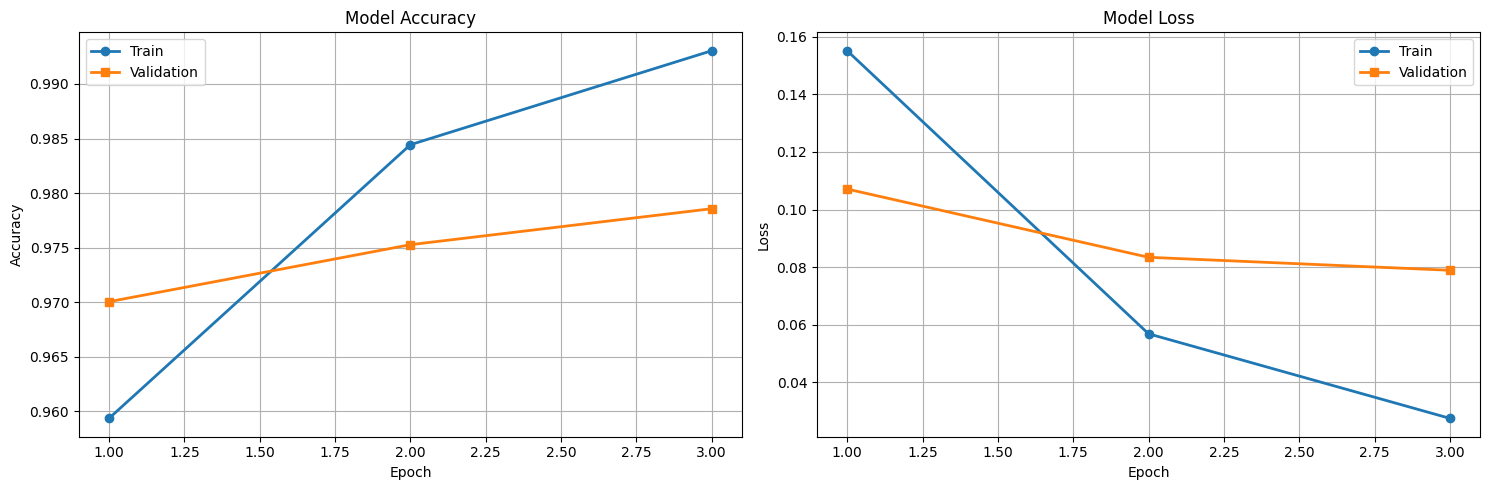


Best Validation Accuracy: 0.9786 (97.86%)


In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(range(1, len(history['train_acc'])+1), history['train_acc'],
             label='Train', marker='o', linewidth=2)
axes[0].plot(range(1, len(history['val_acc'])+1), history['val_acc'],
             label='Validation', marker='s', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss
axes[1].plot(range(1, len(history['train_loss'])+1), history['train_loss'],
             label='Train', marker='o', linewidth=2)
axes[1].plot(range(1, len(history['val_loss'])+1), history['val_loss'],
             label='Validation', marker='s', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Model Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

print(f"\nBest Validation Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")

Step 16: Evaluate on Test Set


In [ ]:
# Load best model
model.load_state_dict(torch.load('best_arabert_model.pt'))

# Test evaluation
print("Evaluating on Test Set...")
test_loss, test_acc = eval_model(model, test_loader, device)

print("\n" + "="*60)
print("TEST SET RESULTS")
print("="*60)
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

Evaluating on Test Set...


Evaluating:   0%|          | 0/569 [00:00<?, ?it/s]


TEST SET RESULTS
Loss: 0.0544
Accuracy: 0.9848 (98.48%)


Step 17: Detailed Classification Report


Getting predictions...


  0%|          | 0/569 [00:00<?, ?it/s]


CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Culture     0.9678    0.9723    0.9701      1300
     Finance     0.9938    0.9877    0.9907      1300
     Medical     0.9870    0.9923    0.9896      1300
    Politics     0.9869    0.9846    0.9858      1300
    Religion     0.9745    0.9700    0.9722      1300
      Sports     0.9985    0.9985    0.9985      1300
        Tech     0.9854    0.9885    0.9869      1300

    accuracy                         0.9848      9100
   macro avg     0.9848    0.9848    0.9848      9100
weighted avg     0.9848    0.9848    0.9848      9100



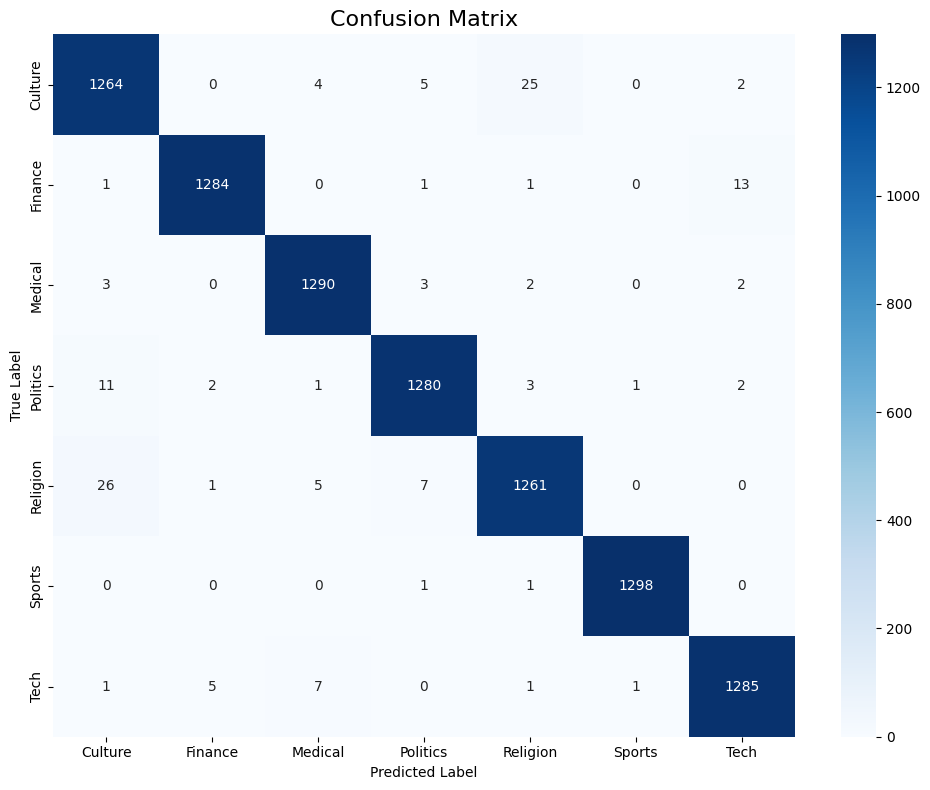

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get all predictions
model.eval()
all_preds = []
all_labels = []

print("Getting predictions...")
with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification Report
print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)
print(classification_report(
    all_labels,
    all_preds,
    target_names=[id_to_label[i] for i in range(num_labels)],
    digits=4
))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[id_to_label[i] for i in range(num_labels)],
            yticklabels=[id_to_label[i] for i in range(num_labels)])
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

Step 18: Test on New Examples


In [ ]:
def predict_news(text, max_length=128):
    model.eval()

    encoding = tokenizer(
        text,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs.logits, dim=1)
        pred = torch.argmax(probs, dim=1).item()
        confidence = probs[0][pred].item()

    return id_to_label[pred], confidence

# Test examples
examples = [
    "الفريق الوطني يفوز بالبطولة الآسيوية في نهائي مثير",
    "ارتفاع أسعار النفط في الأسواق العالمية بنسبة 5%",
    "اكتشاف علاج جديد لمرض السرطان في جامعة الملك سعود",
    "آبل تطلق هاتف آيفون الجديد بتقنية الذكاء الاصطناعي",
    "افتتاح معرض فني للفن الإسلامي المعاصر في الرياض",
    "مجلس الوزراء يعتمد قرارات اقتصادية جديدة",
    "خطبة الجمعة في المسجد الحرام تتحدث عن الصبر"
]

print("\n" + "="*70)
print("TESTING ON NEW EXAMPLES")
print("="*70)

for text in examples:
    pred, conf = predict_news(text)
    print(f"\nText: {text}")
    print(f"Prediction: {pred} (Confidence: {conf*100:.1f}%)")


TESTING ON NEW EXAMPLES

Text: الفريق الوطني يفوز بالبطولة الآسيوية في نهائي مثير
Prediction: Sports (Confidence: 97.1%)

Text: ارتفاع أسعار النفط في الأسواق العالمية بنسبة 5%
Prediction: Finance (Confidence: 99.3%)

Text: اكتشاف علاج جديد لمرض السرطان في جامعة الملك سعود
Prediction: Medical (Confidence: 98.3%)

Text: آبل تطلق هاتف آيفون الجديد بتقنية الذكاء الاصطناعي
Prediction: Tech (Confidence: 99.8%)

Text: افتتاح معرض فني للفن الإسلامي المعاصر في الرياض
Prediction: Culture (Confidence: 98.8%)

Text: مجلس الوزراء يعتمد قرارات اقتصادية جديدة
Prediction: Finance (Confidence: 64.8%)

Text: خطبة الجمعة في المسجد الحرام تتحدث عن الصبر
Prediction: Religion (Confidence: 98.7%)


 Save Model for Future Use

In [ ]:
# Save complete model
model.save_pretrained('./arabert_news_classifier')
tokenizer.save_pretrained('./arabert_news_classifier')

print("Model saved!")
print("\nTo load later:")
print("model = AutoModelForSequenceClassification.from_pretrained('./arabert_news_classifier')")
print("tokenizer = AutoTokenizer.from_pretrained('./arabert_news_classifier')")

Model saved!

To load later:
model = AutoModelForSequenceClassification.from_pretrained('./arabert_news_classifier')
tokenizer = AutoTokenizer.from_pretrained('./arabert_news_classifier')


Download Model to Your Computer

In [ ]:
# Create zip file
!zip -r arabert_news_model.zip best_arabert_model.pt

# Download
from google.colab import files
files.download('arabert_news_model.zip')

print("Model downloaded to your computer!")

  adding: best_arabert_model.pt (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model downloaded to your computer!


 Test with Your Own Text

In [ ]:
# Interactive testing
while True:
    user_text = input("\nEnter Arabic news text (or 'quit' to exit): ")

    if user_text.lower() == 'quit':
        break

    pred, conf = predict_news(user_text)
    print(f"Prediction: {pred} ({conf*100:.1f}% confidence)")


Enter Arabic news text (or 'quit' to exit): رونالدو ينضم للنصر السعودي بصفقة قياسية
Prediction: Sports (96.8% confidence)

Enter Arabic news text (or 'quit' to exit): فنان سعودي يفوز بجائزة عالمية في الفن التشكيلي
Prediction: Culture (95.3% confidence)


KeyboardInterrupt: Interrupted by user

In [ ]:
import shutil
import os

# Create project folder
project_name = "AraBERT_News_Classifier"
os.makedirs(project_name, exist_ok=True)

# Copy all important files to project folder
files_to_save = [
    'best_arabert_model.pt',
    'arabert_news_model.zip'
]

for file in files_to_save:
    if os.path.exists(file):
        shutil.copy(file, f"{project_name}/{file}")
        print(f"Copied: {file}")

# Copy model folder if exists
if os.path.exists('arabert_news_classifier'):
    shutil.copytree('arabert_news_classifier', f"{project_name}/arabert_news_classifier", dirs_exist_ok=True)
    print("Copied: arabert_news_classifier folder")

# Create README file
readme_content = """# AraBERT Arabic News Classifier

## Project Description
Fine-tuned AraBERT model for Arabic news classification into 7 categories:
- Sports
- Politics
- Finance
- Medical
- Tech
- Culture
- Religion

## Dataset
- SANAD Arabic News Dataset
- 45,500 samples
- 7 categories

## Model
- Base Model: aubmindlab/bert-base-arabertv2
- Training: 3 epochs
- Best Validation Accuracy: Check training logs

## Files
- `best_arabert_model.pt`: Trained model weights
- `fine-tuning-news_classfction.ipynb`: Complete training notebook
- `arabert_news_classifier/`: Saved model directory

## Usage
See notebook for complete code and examples.
"""

with open(f"{project_name}/README.md", 'w', encoding='utf-8') as f:
    f.write(readme_content)

print(f"\nProject folder '{project_name}' created successfully!")

Copied: best_arabert_model.pt
Copied: arabert_news_model.zip
Copied: arabert_news_classifier folder

Project folder 'AraBERT_News_Classifier' created successfully!


In [ ]:
# Download current notebook
from google.colab import files

print("Downloading notebook...")
files.download('fine-tuning-news_classfction.ipynb')

FileNotFoundError: Cannot find file: fine-tuning-news_classfction.ipynb

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Copy project folder to Drive
drive_path = '/content/drive/MyDrive/AraBERT_Projects'
os.makedirs(drive_path, exist_ok=True)

# Copy entire project
shutil.copytree(project_name, f"{drive_path}/{project_name}", dirs_exist_ok=True)

print(f"\nProject uploaded to Google Drive:")
print(f"{drive_path}/{project_name}")